In [40]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np

from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import scipy.optimize as opt
import piscola as pisco

import lmfit
import emcee
import corner
from IPython.display import display, Math
from itertools import product

# for absolute magnitudes
from astropy.cosmology import FlatLambdaCDM  
import astropy.units as u
Omega_m = 0.3
H0 = 70.0
cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3)  # B14 

import pickle
with open('rcparams.pickle', 'rb') as file:
    rcparams = pickle.load(file)
    plt.rcParams.update(rcparams)

In [28]:
def decompose(algorithm, features, phases, weights=None, n_components=3, plot=True, save_plot=False, name_plot='decomposition.png'):
    
    kwargs = {}
    if (weights is not None) and ('sklearn' not in str(algorithm)) and ('umap' not in str(algorithm)):
        kwargs = {'weights':weights}
        
    if ('sklearn' in str(algorithm)) or ('wpca' in str(algorithm)) or ('umap' in str(algorithm)):
        reducer = algorithm(n_components=n_components)
        transformed_features = reducer.fit_transform(features, **kwargs) # fits AND transforms at the same time
        try:
            components_ = reducer.components_
        except:
            pass
    else:
        reducer = algorithm(feature_values, n_components=n_components, V=weights)
        reducer.SolveNMF()
        transformed_features = reducer.W
        components_ = reducer.H

    color_palette = [plt.get_cmap('Set1')(i) for i in np.arange(8)] + [plt.get_cmap('Dark2')(i) for i in np.arange(8)]
    color_palette = color_palette[::2]

    # plot
    if ('umap' not in  str(algorithm)) and ('TSNE' not in  str(algorithm)) and plot:
        
        marker_styles = ['s', 'o', 'P', 'X', 4, '>', '*', 'x', 'p', 'X', 5, 'D', '>']
        fig, ax = plt.subplots(figsize=(8, 6))
        
        for i in np.arange(n_components):
            variance = transformed_features[:,i].var()/np.sum(transformed_features.var(axis=0))
            component_array = components_[i,:]
            ax.plot(phases, component_array, marker=marker_styles[i], markersize=8, mec='k',
                    label = f'NMF comp. {i+1} ({int(np.round(100*variance, 0))}%)', color=color_palette[i])

        ax.set_ylabel('Component value', fontsize=20)
        ax.set_xlabel('Days with respect to B-band peak', fontsize=20)
        ax.tick_params('both', labelsize=20)
        ax.legend(fontsize=14)
        if save_plot:
            plt.savefig(f'{name_plot}')
        plt.show()
    
    return reducer, transformed_features


def plot_coef(components_df, params_df):

    n_components = components_df.shape[1]
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(n_components , n_components, wspace=0, hspace=0)

    for i in np.arange(n_components):

        ax = plt.subplot(gs[i, 0])
        if i==0:
            ax.set_ylabel(f'# SNe')
        else:
            ax.set_ylabel(f'Coef. {int(i+1)}')
        for j in np.arange(i+1):

            ax = plt.subplot(gs[i, j])
            if i==j:
                ax.hist(components_df.values[:,i])
                if i!=n_components-1:
                    ax.set_xticklabels([' ']*len(components_df.values[:,i]))
            else:    
                s = ax.scatter(components_df.values[:,j], components_df.values[:,i])

            if (i+1)==n_components:
                ax = plt.subplot(gs[i, j])
                ax.set_xlabel(f'Coef. {int(j+1)}')
            if j != 0:
                ax.set_yticklabels([' ']*len(components_df.values[:,i]))

    #plt.savefig(f'plots/{band}-band_coefficients.pdf')
    plt.show()


def plot_coefvparams(components_df, params_df, param_names=None, save_plot=False, plot_name='coef_vs_lcparams.png'):
    
    if param_names is None:
        param_names = [r'm$_B$', '$\Delta$m$_{15}$', r'($B$ - $V$)$_{\rm max}$', 'M$_B$']
        
    n_components = components_df.shape[1]
    fig, ax = plt.subplots(n_components, params_df.shape[1], figsize=(12, 10), 
                           sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})

    for i in np.arange(n_components):

        ax[i, 0].set_ylabel(r'$p_{%i}$'%(i+1), size=28)
    
        for j in np.arange(params_df.shape[1]):

            ax[i, j].scatter(params_df.values[:,j], components_df.values[:,i])
            ax[i, j].tick_params(axis='both', labelsize=18)

            if (i+1)==n_components:
                ax[i, j].set_xlabel(f'{param_names[j]}')  

    if save_plot:
        plt.savefig(f'{plot_name}')
    plt.show()

In [29]:
def monte_carlo_decomposition(feature_values, dfeature_values, phases, n_components=3, N=1000,
                              plot=True, save_plot=False, name_plot='decomposition.png'):
    
    #iterate in SN
    sample_flux = []
    for lc, lcerr in zip(feature_values, dfeature_values):

        # iterate in epoch
        sn_flux = np.asarray([np.random.normal(flux, err, N) for flux, err in zip(lc, lcerr)])
        sample_flux.append(sn_flux)  # append SN light curve
        
    sample_flux = np.asarray(sample_flux)
    sample_flux[sample_flux < 0] = 0  # remove negative values
    
    # decompose
    transformed_features_list = []
    for i in range(N):
        features = sample_flux[:,:,i]
        reducer, transformed_features = decompose(NMF, features, phases, weights=1/dfeature_values**2, n_components=n_components, plot=False)
        transformed_features_list.append(transformed_features)
    
    transformed_features_array = np.asarray(transformed_features_list)
    transformed_features_array = np.swapaxes(transformed_features_array,0,1)
    transformed_features = np.asarray([np.mean(array, axis=0) for array in transformed_features_array])  # mean values
    dtransformed_features = np.asarray([np.std(array, axis=0) for array in transformed_features_array])  # uncertainties/errors
    
    # covariance
    ctransformed_features = []
    for array, sn_flux in zip(transformed_features_array, sample_flux):
        covariances = []
        for i, j in product(range(n_components), range(n_components)):
            if j <= i:
                continue
            if i==0:
                # the first parameters is going to be mb (flux at phase 0.0) instead of p1
                array[:, i] = sn_flux[np.argmin(np.abs(phases-0.0))]
            cov_matrix = np.cov(array[:, i], array[:, j])
            covariances.append(cov_matrix[0][1])  # choose one of the non-diagonals

        ctransformed_features.append(covariances)
    ctransformed_features = np.asarray(ctransformed_features)
    
    # for plotting purposes
    reducer, transformed_features, decompose(NMF, feature_values, phases, weights=1/dfeature_values**2, 
                                              n_components=n_components, plot=plot, save_plot=save_plot,
                                              name_plot=name_plot)
    
    return reducer, (transformed_features, dtransformed_features, ctransformed_features)

In [30]:
def salt2_residual(params, mb, x1, color, dmb, dx1, dcolor, z, dz=0.0, 
                   log_mass=0.0, dlog_mass=0.0, gamma=0.0,
                   sig_int=0.0, sig_lensing=0.0, sig_hostcorr=0.0, 
                   cov_m_s=0.0, cov_m_c=0.0, cov_s_c=0.0):
    
    try:
        alpha = params['alpha'].value
    except:
        alpha = 0.0
        
    try:
        M = params['M'].value
    except:
        M = 0.0
    
    try:
        beta = params['beta'].value
    except:
        beta = 0.0
        
    try:
        gamma = np.asarray([params['gamma'].value if mass >= 10 
                            else 0.0 for mass in log_mass])
    except:
        pass

    try:
        Omega_m = params['Omega_m'].value
        H0 = 70
        mu_cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_m).distmod(z).value
    except:
        mu_cosmo = cosmo.distmod(z).value
        
    mu_SN = mb - (M + gamma) + alpha*x1 - beta*color
    
    D = (dmb**2 + (alpha**2)*(dx1**2) + (beta**2)*(dcolor**2)
            + (5*dz/(z*np.log(10)))**2
            + sig_lensing**2 + sig_hostcorr**2 + sig_int**2
            + 2*alpha*cov_m_s + 2*(-beta)*cov_m_c + 2*alpha*(-beta)*cov_s_c
           )
    
    Nparams = len(params)
    dof = len(mu_SN) - Nparams
    chi2 = np.sum((mu_SN - mu_cosmo)**2/D)
    
    return chi2

def salt2_mcmc(p0, args, labels=None, nwalkers=32, nsteps=1000, nburn=500, verbose=True, plot=False):

    def log_prior(theta):

        if len(theta) == 2:
            M, alpha = theta
            if -20.0 < M < -18 and 0.0 < alpha < 2.0:
                return 0.0
        
        elif len(theta) == 3:
            M, alpha, beta = theta
            if -20.0 < M < -18 and 0.0 < alpha < 2.0 and 0.0 < beta < 8.0:
                return 0.0
            
        elif len(theta) == 4:
            M, alpha, beta, gamma = theta
            if -20.0 < M < -18 and 0.0 < alpha < 2.0 and 0.0 < beta < 8.0 and -0.2 < gamma < 0.2:
                return 0.0
            
        elif len(theta) == 5:
            M, alpha, beta, gamma, Omega_m = theta
            if -20.0 < M < -18 and 0.0 < alpha < 2.0 and 0.0 < beta < 8.0 and -0.2 < gamma < 0.2 and 0.0 < Omega_m < 1.0:
                return 0.0
            
        return -np.inf

    def log_likelihood(theta, mb, x1, color, dmb, dx1, dcolor, z, dz=0.0, 
                       log_mass=0.0, dlog_mass=0.0, gamma=0.0,
                       sig_int=0.0, sig_lensing=0.0, sig_hostcorr=0.0, 
                       cov_m_s=0.0, cov_m_c=0.0, cov_s_c=0.0):

        if len(theta) == 2:
            M, alpha = theta
            beta = 0.0
            mu_cosmo = cosmo.distmod(z).value
        elif len(theta) == 3:
            M, alpha, beta = theta
            mu_cosmo = cosmo.distmod(z).value
        elif len(theta) == 4:
            M, alpha, beta, gamma = theta
            gamma = np.asarray([gamma if mass >= 10 else 0.0 for mass in log_mass])
            mu_cosmo = cosmo.distmod(z).value
        elif len(theta) == 5:
            M, alpha, beta, gamma, Omega_m = theta
            gamma = np.asarray([gamma if mass >= 10 else 0.0 for mass in log_mass])
            H0 = 70
            mu_cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_m).distmod(z).value
            
        mu_SN = mb - (M + gamma) + alpha*x1 - beta*color

        D = (dmb**2 + (alpha**2)*(dx1**2) + (beta**2)*(dcolor**2)
                    + (5*dz/(z*np.log(10)))**2
                    + sig_lensing**2 + sig_hostcorr**2 + sig_int**2
                    + 2*alpha*cov_m_s + 2*(-beta)*cov_m_c + 2*alpha*(-beta)*cov_s_c
                   )
        
        return -0.5*np.sum((mu_SN - mu_cosmo)**2/D + np.log(D))

    def log_probability(theta, mb, x1, color, dmb, dx1, dcolor, z, dz=0.0, 
                       log_mass=0.0, dlog_mass=0.0, gamma=0.0,
                       sig_int=0.0, sig_lensing=0.0, sig_hostcorr=0.0, 
                       cov_m_s=0.0, cov_m_c=0.0, cov_s_c=0.0):

        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, mb, x1, color, dmb, dx1, dcolor, z, dz, 
                                   log_mass, dlog_mass, gamma, sig_int, sig_lensing, sig_hostcorr, 
                                   cov_m_s, cov_m_c, cov_s_c)

    ndim = len(p0)
    pos = p0 + 1e-4*np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
    sampler.run_mcmc(pos, nsteps);
    samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
    
    if plot==True:
        if labels is None:
            labels = [f'param{i}' for i in ndim]
        fig = corner.corner(samples, labels=labels)
        plt.show()
        
    results = list()
    errors = list()
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        results.append(mcmc[1])
        q = np.diff(mcmc)
        errors.append(q)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i].replace('$', ''))
        if verbose==True:
            display(Math(txt))
        
    return results, errors

##########################################################################################

def pisco_residual(params, mb, p2, p3, color, dmb, dp2, dp3, dcolor, z, dz=0.0, 
                   log_mass=0.0, dlog_mass=0.0, gamma=0.0,
                   sig_int=0.0, sig_lensing=0.0, sig_hostcorr=0.0, 
                   cov_m_p2=0.0, cov_m_p3=0.0, cov_m_c=0.0,
                   cov_p2_p3=0.0, cov_p2_c=0.0, cov_p3_c=0.0):
    
    try:
        eta = params['eta'].value
    except:
        eta = 0.0
        
    try:
        M = params['M'].value
    except:
        M = 0.0
    
    try:
        theta = params['theta'].value
    except:
        theta = 0.0
    
    try:
        beta = params['beta'].value
    except:
        beta = 0.0
        
    try:
        gamma = np.asarray([params['gamma'].value if mass >= 10 
                            else 0.0 for mass in log_mass])
    except:
        pass

    try:
        Omega_m = params['Omega_m'].value
        H0 = 70
        mu_cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_m).distmod(z).value
    except:
        mu_cosmo = cosmo.distmod(z).value
        
    mu_SN = mb - (M + gamma) + eta*p2 + theta*p3 - beta*color
    
    D = (dmb**2 + (eta**2)*(dp2**2) + (theta**2)*(dp3**2) + (beta**2)*(dcolor**2)
            + (5*dz/(z*np.log(10)))**2
            + sig_lensing**2 + sig_hostcorr**2 + sig_int**2
            + 2*eta*cov_m_p2 + 2*theta*cov_m_p3 + 2*(-beta)*cov_m_c 
            + 2*eta*theta*cov_p2_p3 + 2*eta*(-beta)*cov_p2_c
            + 2*theta*(-beta)*cov_p3_c
           )
    
    Nparams = len(params)
    dof = len(mu_SN) - Nparams
    chi2 = np.sum((mu_SN - mu_cosmo)**2/D)
    
    return chi2

def pisco_mcmc(p0, args, labels=None, nwalkers=32, nsteps=1000, nburn=500, verbose=True, plot=False):

    def log_prior(params):
        
        try:
            i = labels.index('M')
            M = params[i]
            constrain_M = -20.0 < M < -18
        except:
            constrain_M = True
        try:
            i = labels.index(r'$\eta$')
            eta = params[i]
            constrain_eta = -8.0 < eta < 8.0
        except:
            constrain_eta = True
        try:
            i = labels.index(r'$\theta$')
            theta = params[i]
            constrain_theta = -8.0 < theta < 8.0
        except:
            constrain_theta = True
        try:
            i = labels.index(r'$\beta$')
            beta = params[i]
            constrain_beta = -8.0 < beta < 8.0
        except:
            constrain_beta = True
        try:
            i = labels.index(r'$\gamma$')
            gamma = params[i]
            constrain_gamma = -0.2 < gamma < 0.2
        except:
            constrain_gamma = True
        try:
            i = labels.index(r'$\Omega_m$')
            Omega_m = params[i]
            constrain_Omega_m = 0.0 < Omega_m < 1.0
        except:
            constrain_Omega_m = True
        
        if constrain_M and constrain_eta and constrain_theta and constrain_beta and constrain_gamma and constrain_Omega_m:
                return 0.0
            
        return -np.inf

    def log_likelihood(params, mb, p2, p3, color, dmb, dp2, dp3, dcolor, z, dz=0.0, 
                       log_mass=0.0, dlog_mass=0.0, gamma=0.0,
                       sig_int=0.0, sig_lensing=0.0, sig_hostcorr=0.0, 
                       cov_m_p2=0.0, cov_m_p3=0.0, cov_m_c=0.0,
                       cov_p2_p3=0.0, cov_p2_c=0.0, cov_p3_c=0.0):
  
        try:
            i = labels.index('M')
            M = params[i]
        except:
            M = 0.0
        try:
            i = labels.index(r'$\eta$')
            eta = params[i]
        except:
            eta = 0.0
        try:
            i = labels.index(r'$\theta$')
            theta = params[i]
        except:
            theta = 0.0
        try:
            i = labels.index(r'$\beta$')
            beta = params[i]
        except:
            beta = 0.0
        try:
            i = labels.index(r'$\gamma$')
            gamma = np.asarray([params[i] if mass >= 10 else 0.0 for mass in log_mass])
        except:
            pass        
        try:
            i = labels.index(r'$\Omega_m$')
            Omega_m = params[i]
            H0 = 70
            mu_cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_m).distmod(z).value
        except:
            mu_cosmo = cosmo.distmod(z).value
            
        mu_SN = mb - (M + gamma) + eta*p2 + theta*p3 - beta*color

        D = (dmb**2 + (eta**2)*(dp2**2) + (theta**2)*(dp3**2) + (beta**2)*(dcolor**2)
            + (5*dz/(z*np.log(10)))**2
            + sig_lensing**2 + sig_hostcorr**2 + sig_int**2
            + 2*eta*cov_m_p2 + 2*theta*cov_m_p3 + 2*(-beta)*cov_m_c 
            + 2*eta*theta*cov_p2_p3 + 2*eta*(-beta)*cov_p2_c
            + 2*theta*(-beta)*cov_p3_c
           )
        
        return -0.5*np.sum((mu_SN - mu_cosmo)**2/D + np.log(D))

    def log_probability(params, mb, p2, p3, color, dmb, dp2, dp3, dcolor, z, dz=0.0, 
                       log_mass=0.0, dlog_mass=0.0, gamma=0.0,
                       sig_int=0.0, sig_lensing=0.0, sig_hostcorr=0.0, 
                       cov_m_p2=0.0, cov_m_p3=0.0, cov_m_c=0.0,
                       cov_p2_p3=0.0, cov_p2_c=0.0, cov_p3_c=0.0):

        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params, mb, p2, p3, color, dmb, dp2, dp3, dcolor, z, dz, 
                                   log_mass, dlog_mass, gamma, sig_int, sig_lensing, sig_hostcorr, 
                                   cov_m_p2, cov_m_p3, cov_m_c, cov_p2_p3, cov_p2_c, cov_p3_c)

    ndim = len(p0)
    pos = p0 + 1e-4*np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
    sampler.run_mcmc(pos, nsteps);
    samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
    
    if plot==True:
        if labels is None:
            labels = [f'param{i}' for i in ndim]
        fig = corner.corner(samples, labels=labels)
        plt.show()
        
    results = list()
    errors = list()
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        results.append(mcmc[1])
        q = np.diff(mcmc)
        errors.append(q)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i].replace('$', ''))
        if verbose==True:
            display(Math(txt))
        
    return results, errors 

# Set Data

___
___
___
# Pantheon

In [107]:
fitted_lightcurves = True  # use interpolated rest-frame light curves instead of the discrete ones

SAMPLE = 'pantheon'
sample_df = pd.read_csv(f'{SAMPLE}_sample.csv')
sn_names = sample_df.sn.values

#bands = ['Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I']
bands = ['Bessell_B']
features_dict = {band:{'flux':[], 'flux_err':[], 'phase':[], 'sn':[]} for band in bands}

for name in sn_names:
    
    sn = pisco.load_sn(name, path=f'obj_{SAMPLE}/')
    mu = cosmo.distmod(sn.z).value

    for band in bands:
        if fitted_lightcurves:
            j = 100  # index step
            phase, flux = sn.corrected_lcs_fit[band]['phase'][::j], sn.corrected_lcs_fit[band]['flux'][::j]
            flux_err = sn.corrected_lcs_fit[band]['err'][::j]
        else:
            phase, flux = sn.corrected_lcs[band]['phase'], sn.corrected_lcs[band]['flux']
            flux_err = sn.corrected_lcs[band]['err']

        flux10 = flux * 10**(0.4*mu)  # flux at 10 pc
        flux10_err = flux_err * 10**(0.4*mu)  # flux error
        features_dict[band]['flux'].append(flux10)  
        features_dict[band]['flux_err'].append(flux10_err)  
        features_dict[band]['phase'].append(phase)
        features_dict[band]['sn'].append(name)
    
        
features_df = {band:None for band in bands}
dfeatures_df = {band:None for band in bands}
if fitted_lightcurves:
    phases = np.round(np.arange(-10, 20.1, 0.1), 1)
else:
    phases = np.round(np.arange(-10, 21, 1), 0)

for band in bands:
    fluxes = []
    fluxes_err = []
    for sn_phases, sn_fluxes, sn_fluxes_err in zip(features_dict[band]['phase'], 
                                                   features_dict[band]['flux'], 
                                                   features_dict[band]['flux_err']):

        phase_fluxes = np.asarray([sn_fluxes[np.argmin(np.abs(phase-sn_phases))] 
                                   if phase in np.round(sn_phases, 1) else np.nan for phase in phases])
        phase_fluxes_err = np.asarray([sn_fluxes_err[np.argmin(np.abs(phase-sn_phases))] 
                                       if phase in np.round(sn_phases, 1) else 1e9 for phase in phases])
                
        fluxes.append(phase_fluxes)
        fluxes_err.append(phase_fluxes_err)

    fluxes = np.asarray(fluxes)
    fluxes_err = np.asarray(fluxes_err)
    print(band, fluxes.shape)
    
    # flux
    new_col = {phase:f for phase, f in zip(phases, fluxes.T)}
    new_col['sn'] = features_dict[band]['sn']
    features_df[band] = pd.DataFrame(new_col).set_index('sn')
    
    # flux err
    new_col = {phase:ferr for phase, ferr in zip(phases, fluxes_err.T)}
    new_col['sn'] = features_dict[band]['sn']
    dfeatures_df[band] = pd.DataFrame(new_col).set_index('sn')
    
sample_df = sample_df[sample_df.sn.isin(sn_names)]

Bessell_U (758, 301)
Bessell_B (758, 301)
Bessell_V (758, 301)
Bessell_R (758, 301)
Bessell_I (758, 301)


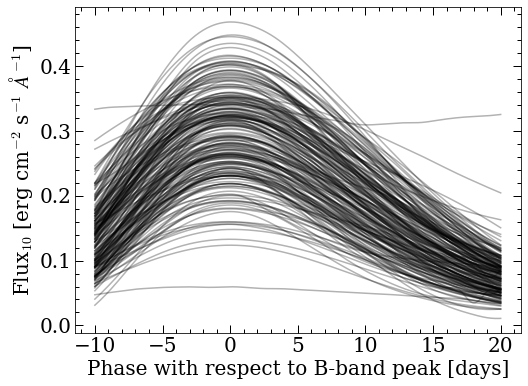

N = 208 SNe (Bessell_B)


In [42]:
band = 'Bessell_B'
normalise = False

feature_values = features_df[band].values
dfeature_values = dfeatures_df[band].values
if normalise:
    feature_values = features_df[band].div(features_df[band][0], axis='index').values
    dfeature_values = dfeatures_df[band].div(features_df[band][0], axis='index').values
params_df = sample_df[sample_df.sn.isin(features_df[band].index.values)]

# delete the SN with any negative flux and nan values
pos_idx = [i for i, sn_values in enumerate(feature_values) if all(sn_values>0.0)] 
feature_values = feature_values[pos_idx]
dfeature_values = dfeature_values[pos_idx]
params_df = params_df.iloc[pos_idx]

#scaler = StandardScaler()
#feature_values = scaler.fit_transform(feature_values)

exp = np.round(np.log10(feature_values[0].max()), 0)
y_norm = 10**exp    

# delete other SNe by eye
delete = True
if delete:
    delete_dict = {} 

    sn2detele = ['SDSS13072', 'SDSS15772', 'SDSS16211', 'SDSS16232', 'SDSS18091', 
                 'SDSS18617', 'SDSS19027', 'SDSS19632', 'SDSS2330', 'SDSS5391']
    #sn2detele = sn2detele + [name for name in params_df.sn if 'sn' in name]
    sn2detele = sn2detele + [name for name in params_df.sn if 'SDSS' in name]
    #sn2detele = sn2detele + [name for name in params_df.sn if params_df.index.startswith('0') in name]
    sn2detele = sn2detele + [name for name in params_df.sn if 'psc' in name]

    mask = params_df.sn.isin(sn2detele)
    params_df = params_df[~mask]
    feature_values = feature_values[~mask]
    dfeature_values = dfeature_values[~mask]

fig, ax = plt.subplots(figsize=(8, 6))
for sn_flux, sn_flux_err in zip(feature_values, dfeature_values):
    ax.plot(phases, sn_flux/y_norm, 'k', alpha=0.3)

ax.set_xlabel(f'Phase with respect to B-band peak [days]', fontsize=20)
#ax.set_ylabel(r'Flux [10$^{%.0f}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp)
ax.set_ylabel(r'Flux$_{10}$ [erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp, fontsize=20)
ax.tick_params('both', labelsize=20)

#plt.savefig(f'plots/{band}-band_lcs.pdf')
plt.show()

print(f'N = {len(params_df)} SNe ({band})')

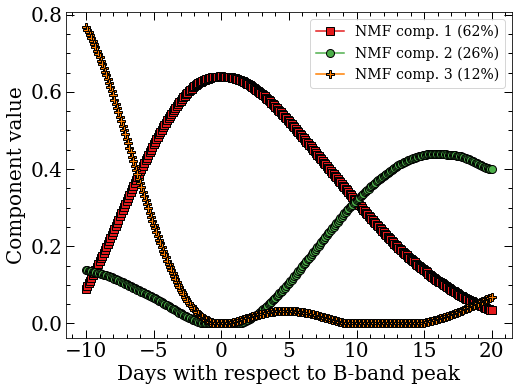

In [45]:
n_components = 3
include_errors = False

if include_errors:
    reducer, results = monte_carlo_decomposition(feature_values, dfeature_values, phases, n_components=n_components, N=100,
                                                # save_plot=True, name_plot='plots/lc_components.pdf'
                                                )
    transformed_features, dtransformed_features, ctransformed_features = results
else:
    reducer, transformed_features = decompose(NMF, feature_values, phases, weights=1/dfeature_values**2, 
                                              n_components=n_components)

In [46]:
sn_names = params_df.sn.values

components_df = pd.DataFrame(data=transformed_features, columns=[f'p{int(i+1)}' for i in np.arange(n_components)])
components_df['sn'] = sn_names
if include_errors:
    dcomponents_df = pd.DataFrame(data=dtransformed_features, columns=[f'dp{int(i+1)}' for i in np.arange(n_components)])
    ccomponents_df = pd.DataFrame(data=ctransformed_features, columns=['cov_m_p2', 'cov_m_p3', 'cov_p2_p3'])
    dcomponents_df['sn'] = ccomponents_df['sn'] = sn_names
    
# Pantheon
pantheon_file = 'test_files/Pantheon/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres'
pantheon_df = pd.read_csv(pantheon_file, delim_whitespace=True)

pantheon_df.CID.iloc[571:743] = 'sn' + pantheon_df.CID.iloc[571:743].astype(str)
pantheon_df.CID.iloc[236:571] = 'SDSS' + pantheon_df.CID.iloc[236:571].astype(str)
pantheon_df.CID.iloc[743:1022] = 'psc' + pantheon_df.CID.iloc[743:1022].astype(str)

pantheon_df = pantheon_df[pantheon_df.CID.isin(sn_names)].sort_values('CID')

/home/muller/anaconda3/envs/pisco/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<ipython-input-47-738877e1532e>:1: RuntimeWarning: invalid value encountered in greater
  mask = pantheon_df.CID.isin(params_df[params_df.color.values>-100].sn.values)


Chi² = 0.95, +/- 0.17
Residual = 0.000 +/- 0.124
71 SNe


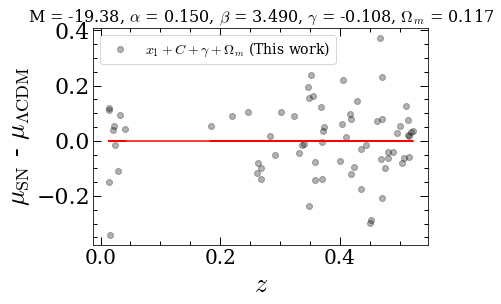

In [47]:
mask = pantheon_df.CID.isin(params_df[params_df.color.values>-100].sn.values)
#mask = pantheon_df.CID.isin(params_df[(params_df.color.values>-100) & (np.abs(params_df.mb.values-pantheon_df.mB.values-0.25)<0.1)].sn.values) 
pantheon_df_masked = pantheon_df[mask]

z1 = pantheon_df_masked.zCMB.values
dz1 = pantheon_df_masked.zCMBERR.values

mb = pantheon_df_masked.mB.values - pantheon_df_masked.biasCor_mu.values
dmb = pantheon_df_masked.mBERR.values
x1 = pantheon_df_masked.x1.values
dx1 = pantheon_df_masked.x1ERR.values
color = pantheon_df_masked.c.values
dcolor = pantheon_df_masked.cERR.values
log_mass = pantheon_df_masked.HOST_LOGMASS.values
dlog_mass = pantheon_df_masked.HOST_LOGMASS_ERR.values

# CHANGE COV_x0_x1 AND COV_x0_c!!!!!!! WHERE IS COV_m_c and COV_m_s????
cov_m_s = pantheon_df_masked.COV_x1_x0.values
cov_m_c = pantheon_df_masked.COV_c_x0.values
cov_s_c = pantheon_df_masked.COV_x1_c.values

### error budget ###
int_dict = {i:0.134 for i in [5, 61, 62, 63, 64, 65, 66]}  # Low-z (B14)
int_dict.update({1:0.108})  # SDSS (B14)
int_dict.update({4:0.080})  # SNLS (B14)
int_dict.update({15:0.080})  # PS1 (Scolnic18 - G10 scatter model)
int_dict.update({i:0.100 for i in [100, 101, 106]})  # HST (B14)
sig_int = np.asarray([int_dict[sample] for sample in pantheon_df_masked.IDSURVEY.values])

sig_lensing = 0.055*z1  # Jönsson10
sig_hostcorr = 0.0  # mass step uncertainty
####################

gamma = 0.0  # gamma comes as output below
args=(mb, x1, color, dmb, dx1, dcolor, z1, dz1, log_mass, dlog_mass, 
      gamma, sig_int, sig_lensing, sig_hostcorr, cov_m_s, cov_m_c, cov_s_c)

minim = 'lmfit'

if minim=='lmfit':
    params = lmfit.Parameters()
    params.add('M', value=-19.05, min=-21, max=-17)
    params.add('alpha', value=0.141, min=-2, max=2)  
    params.add('beta', value=3.101, min=-5, max=5)  
    params.add('gamma', value=-0.06, min=-1, max=1)
    params.add('Omega_m', value=0.3, min=0, max=1)
    # methods: leastsq, least_squares, nelder, bfgs
    result = lmfit.minimizer.minimize(fcn=salt2_residual, params=params, args=args, method='nelder')
    M, alpha, beta = result.params['M'].value, result.params['alpha'].value, result.params['beta'].value
    gamma = np.asarray([result.params['gamma'].value if mass>=10 else 0.0 for mass in log_mass])
    Omega_m = result.params['Omega_m'].value
    Nparams = len(params)
    
elif minim=='mcmc':
    p0 = np.asarray([-19, 0.3, 3, -0.06, 0.3])
    mcmc_labels = ['M', r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\Omega_m$']
    result, errors = salt2_mcmc(p0, args, labels=mcmc_labels, nsteps=1000, nburn=300, verbose=False, plot=True)
    M, alpha, beta, gamma, Omega_m = result
    gamma = np.asarray([gamma if mass>=10 else 0.0 for mass in log_mass])
    Nparams = len(result)

mu_cosmo1 = FlatLambdaCDM(H0=H0, Om0=Omega_m).distmod(z1).value
mu_SN1 = mb - (M + gamma) + alpha*x1 - beta*color
   
D = (dmb**2 + (alpha**2)*(dx1**2) + (beta**2)*(dcolor**2)
            + (5*dz1/(z1*np.log(10)))**2
            + sig_lensing**2 + sig_hostcorr**2 + sig_int**2
            + 2*alpha*cov_m_s + 2*(-beta)*cov_m_c + 2*alpha*(-beta)*cov_s_c
    )

HR1 = mu_SN1 - mu_cosmo1

dof = len(mu_cosmo1) - Nparams
chi2 = np.sum(HR1**2/D)
red_chi2, sig = chi2/dof, np.sqrt(2/dof)
print(f'Chi² = {red_chi2:.2f}, +/- {sig:.2f}')
wmean1 = np.average(HR1, weights=1/D)
wstd1 = np.sqrt(np.average((HR1 - wmean1)**2, weights=1/D))
print(f'Residual = {wmean1:.3f} +/- {wstd1:.3f}')
print(f'{len(mu_cosmo1)} SNe')

plt.title(r'M = %.2f, $\alpha$ = %.3f, $\beta$ = %.3f, $\gamma$ = %.3f, $\Omega_m$ = %.3f'%(M, alpha,
                                                            beta, np.min(gamma), Omega_m), fontsize=16)
plt.plot(z1, HR1, 'ko', alpha=0.3, label='$x_1 + C + \gamma + \Omega_m$ (This work)')
plt.plot(z1, mu_cosmo1-mu_cosmo1, 'r-')
plt.xlabel('$z$', fontsize=26)
plt.ylabel(r'$\mu_{\rm SN}$ - $\mu_{\Lambda \rm CDM}$', fontsize=26)
plt.legend(fontsize=14)
plt.show()

<ipython-input-25-0f34b9b8498c>:2: RuntimeWarning: invalid value encountered in greater
  color_mask = np.where(params_df.color.values>-100)


Chi² = 2.46, +/- 0.18
Residual = 0.001 +/- 0.175
71 SNe


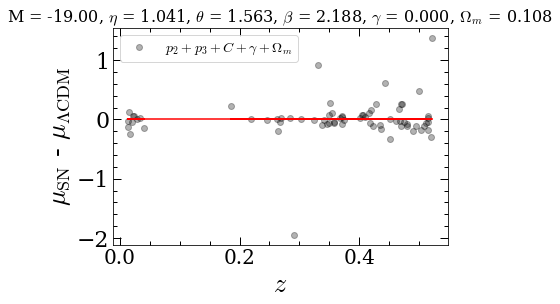

In [25]:
# mask
color_mask = np.where(params_df.color.values>-100)
#color_mask = np.where((params_df.color.values>-100)&(np.abs(params_df.mb.values-pantheon_df.mB.values-0.25)<0.1))
color = params_df.color.values[color_mask]
dcolor = params_df.dcolor.values[color_mask]

p2 = components_df['p2'].values[color_mask]
p3 = components_df['p3'].values[color_mask]

if include_errors:
    dp2 = dcomponents_df['dp2'].values[color_mask]
    dp3 = dcomponents_df['dp3'].values[color_mask]
    cov_m_p2 = ccomponents_df['cov_m_p2'].values[color_mask]
    cov_m_p3 = ccomponents_df['cov_m_p3'].values[color_mask]
    cov_p2_p3 = ccomponents_df[f'cov_p2_p3'].values[color_mask]
    cov_m_c = cov_p2_c = cov_p3_c = 0.0
else:
    dp2 = dp3 = 0.0
    cov_m_p2 = cov_m_p3 = cov_p2_p3 = 0.0
    cov_m_c = cov_p2_c = cov_p3_c = 0.0

biascor = pantheon_df_masked.biasCor_mu.values

z = params_df.z.values[color_mask]
dz = pantheon_df_masked.zCMBERR.values

mb = params_df.mb.values[color_mask] - biascor
dmb = params_df.dmb.values[color_mask]
log_mass = pantheon_df_masked.HOST_LOGMASS.values
dlog_mass = pantheon_df_masked.HOST_LOGMASS_ERR.values

### error budget ###
int_dict = {i:0.134 for i in [5, 61, 62, 63, 64, 65, 66]}  # Low-z (B14)
int_dict.update({1:0.108})  # SDSS (B14)
int_dict.update({4:0.080})  # SNLS (B14)
int_dict.update({15:0.080})  # PS1 (Scolnic18 - G10 scatter model)
int_dict.update({i:0.100 for i in [100, 101, 106]})  # HST (B14)
sig_int = np.asarray([int_dict[sample] for sample in pantheon_df_masked.IDSURVEY.values])

sig_lensing = 0.055*z  # Jönsson10
sig_hostcorr = 0.0  # mass step uncertainty
##########################################

gamma = 0.0  # gamma comes as output below
args=(mb, p2, p3, color, dmb, dp2, dp3, dcolor, z, dz, log_mass, dlog_mass,
      gamma, sig_int, sig_lensing, sig_hostcorr, cov_m_p2, cov_m_p3, cov_m_c,
      cov_p2_p3, cov_p2_c, cov_p3_c)

minim = 'lmfit'

if minim=='lmfit':
    params = lmfit.Parameters()
    params.add('M', value=-19, min=-21, max=-17)
    params.add('eta', value=6.0, min=0, max=80)  
    params.add('theta', value=3.0, min=0, max=80)
    params.add('beta', value=2.0, min=0, max=5)
    params.add('gamma', value=-0.06, min=-1, max=1)
    params.add('Omega_m', value=0.3, min=0, max=1)
    # methods: leastsq, least_squares, nelder, bfgs
    result = lmfit.minimizer.minimize(fcn=pisco_residual, params=params, args=args, method='nelder')
    M = result.params['M'].value 
    eta = result.params['eta'].value
    theta = result.params['theta'].value
    beta = result.params['beta'].value
    gamma = np.asarray([result.params['gamma'].value if mass>=10 else 0.0 for mass in log_mass])
    Omega_m = result.params['Omega_m'].value
    Nparams = len(params)
    
elif minim=='mcmc':
    params = {'M':-19, 
             r'$\eta$':6, 
             r'$\theta$':3, 
             r'$\beta$':2, 
             r'$\gamma$':-0.06, 
             r'$\Omega_m$':0.3
             }
    p0 = np.asarray(list(params.values()))
    mcmc_labels = list(params.keys())
    result, errors = pisco_mcmc(p0, args, labels=mcmc_labels, nsteps=1000, nburn=300, verbose=False, plot=True)
    M, eta, theta, beta, gamma, Omega_m = result
    gamma = np.asarray([gamma if mass>=10 else 0.0 for mass in log_mass])
    Nparams = len(params)

mu_cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_m).distmod(z).value
mu_SN = mb - (M + gamma) + eta*p2 + theta*p3 - beta*color
    
D = (dmb**2 + (eta**2)*(dp2**2) + (theta**2)*(dp3**2) + (beta**2)*(dcolor**2)
            + (5*dz/(z*np.log(10)))**2
            + sig_lensing**2 + sig_hostcorr**2 + sig_int**2
            + 2*eta*cov_m_p2 + 2*theta*cov_m_p3 + 2*(-beta)*cov_m_c 
            + 2*eta*theta*cov_p2_p3 + 2*eta*(-beta)*cov_p2_c
            + 2*theta*(-beta)*cov_p3_c
           )

HR = mu_SN - mu_cosmo

dof = len(mu_cosmo) - Nparams
chi2 = np.sum(HR**2/D)
red_chi2, sig = chi2/dof, np.sqrt(2/dof)
print(f'Chi² = {red_chi2:.2f}, +/- {sig:.2f}')
wmean = np.average(HR, weights=1/D)
wstd = np.sqrt(np.average((HR - wmean)**2, weights=1/D))
print(f'Residual = {wmean:.3f} +/- {wstd:.3f}')
print(f'{len(mu_cosmo)} SNe')

plt.title(r'M = %.2f, $\eta$ = %.3f, $\theta$ = %.3f, $\beta$ = %.3f, $\gamma$ = %.3f, $\Omega_m$ = %.3f'%(M, eta, 
                                                            theta, beta, np.min(gamma), Omega_m), fontsize=16)
plt.plot(z, HR, 'ko', alpha=0.3, label=r'$p_2 + p_3 + C + \gamma + \Omega_m$')
plt.plot(z, mu_cosmo-mu_cosmo, 'r-')
plt.xlabel('$z$', fontsize=26)
plt.ylabel(r'$\mu_{\rm SN}$ - $\mu_{\Lambda \rm CDM}$', fontsize=26)
plt.legend(fontsize=14)
plt.show()

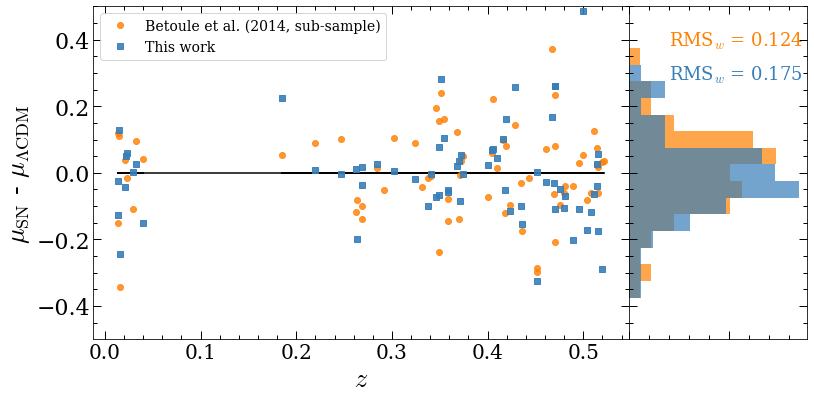

With 2.8 significance
RMS (This Work) = 0.340, RMS (Betoule+14) = 0.129, significance = 6.9
0.48, 0.52


In [26]:
err_wstd1 = wstd1/np.sqrt(2*(len(HR1)-1))
err_wstd = wstd/np.sqrt(2*(len(HR)-1))
significance = np.abs(wstd-wstd1)/np.sqrt(err_wstd1**2 + err_wstd**2)

palette = [plt.get_cmap('Set1')(i) for i in np.arange(8)]
fig, ax =plt.subplots(1, 2, figsize=(12, 6), sharey=True, gridspec_kw = {'width_ratios':[3, 1]})

ax[0].errorbar(z1, HR1, color=palette[4], fmt='o', alpha=0.8, label=r'Betoule et al. (2014, sub-sample)')
ax[0].errorbar(z, HR, color=palette[1], fmt='s', alpha=0.9, label=f'This work')
ax[0].plot(z, mu_cosmo-mu_cosmo, 'k-')

bins = np.arange(-0.45, 0.45, 0.05)+0.025
ax[1].hist(HR1, bins, color=palette[4], density=True, alpha=0.7, orientation="horizontal")
ax[1].hist(HR, bins, color=palette[1], density=True, alpha=0.7, orientation="horizontal")

ax[1].text(1., 0.38, r'RMS$_w$ = %.3f'%wstd1, color=palette[4], fontsize=18)
ax[1].text(1., 0.28, r'RMS$_w$ = %.3f'%wstd, color=palette[1], fontsize=18)

ax[0].set_xlabel('$z$', fontsize=26)
ax[0].set_ylabel(r'$\mu_{\rm SN}$ - $\mu_{\Lambda \rm CDM}$', fontsize=26)
ax[0].legend(fontsize=14)

ax[1].set_xticklabels([])
ax[0].set_ylim(-0.5, 0.5)
ax[1].set_ylim(-0.5, 0.5)
plt.tight_layout()
fig.subplots_adjust(wspace=0)
#plt.savefig('plots/residual_comparison2.pdf')
plt.show()

########################
err_wstd1 = wstd1/np.sqrt(2*(len(HR1)-1))
err_wstd = wstd/np.sqrt(2*(len(HR)-1))
significance = np.abs(wstd-wstd1)/np.sqrt(err_wstd1**2 + err_wstd**2)
print(f'With {significance:.1f} significance')

mean1 = np.average(HR1)
std1 = np.sqrt(np.average((HR1 - mean1)**2))
mean = np.average(HR)
std = np.sqrt(np.average((HR - mean)**2))
err_std1 = std1/np.sqrt(2*(len(HR1)-1))
err_std = std/np.sqrt(2*(len(HR)-1))
significance = np.abs(std-std1)/np.sqrt(err_std1**2 + err_std**2)
print(f'RMS (This Work) = {std:.3f}, RMS (Betoule+14) = {std1:.3f}, significance = {significance:.1f}')

print(f'{len(HR[HR>0.0])/len(HR):.2f}, {len(HR1[HR1>0.0])/len(HR1):.2f}')